# Structure from Motion (SfM) Notebook

This notebook demonstrates how to generate a 3D point cloud from a set of images using Structure from Motion (SfM) techniques.
We'll use OpenCV for feature extraction, matching, and triangulation.
Ensure you have the necessary images in the specified directory.


In [60]:
import cv2
import numpy as np
import os
import glob
from matplotlib import pyplot as plt

# Set paths
data_in = "data"
data_set = "globe"
data_out = "out"

# Create output directory if it doesn't exist
os.makedirs(data_out, exist_ok=True)

## Step 1: Feature Extraction and Matching


In [61]:
# Load images
image_paths = sorted(glob.glob(os.path.join(data_in, data_set, "*.JPG")))
images = [cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) for img_path in image_paths]

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Extract features and match them
keypoints = []
descriptors = []
for img in images:
    kp, des = sift.detectAndCompute(img, None)
    keypoints.append(kp)
    descriptors.append(des)

# Match features between consecutive images
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = []
for i in range(len(images) - 1):
    matches.append(bf.match(descriptors[i], descriptors[i + 1]))

# Sort matches by distance
matches = [sorted(m, key=lambda x: x.distance) for m in matches]

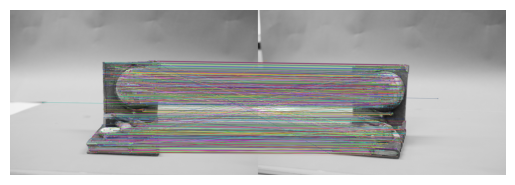

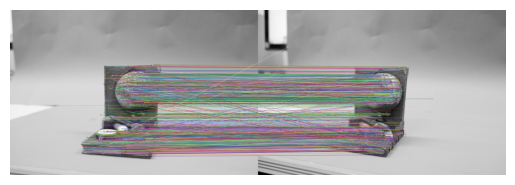

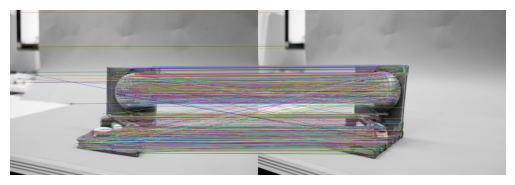

In [62]:
# Plot matches
for i in range(3):
    img_i = cv2.drawMatches(
        images[i],
        keypoints[i],
        images[i + 1],
        keypoints[i + 1],
        matches[i],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )

    plt.imshow(img_i)
    plt.axis("off")
    plt.show()

## Step 2: Eliminate Outliers


In [63]:
# Remove outliers from matches using cv2.findHomography

for i in range(len(images) - 1):
    kp1 = np.array([keypoints[i][m.queryIdx].pt for m in matches[i]])
    kp2 = np.array([keypoints[i + 1][m.trainIdx].pt for m in matches[i]])

    H, mask = cv2.findHomography(kp1, kp2, cv2.RANSAC, 4.0)

    matches[i] = [m for m, msk in zip(matches[i], mask) if msk]

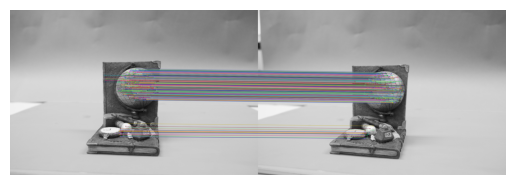

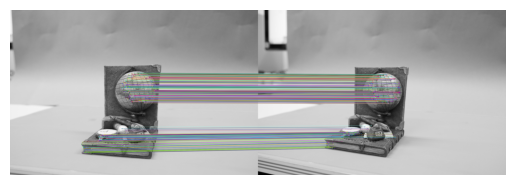

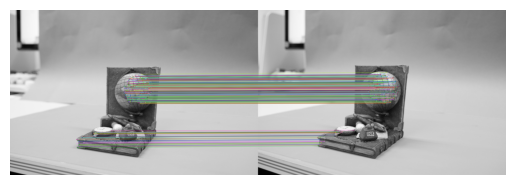

In [64]:
# Plot matches
for i in range(3):
    img_i = cv2.drawMatches(
        images[i],
        keypoints[i],
        images[i + 1],
        keypoints[i + 1],
        matches[i],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    )

    plt.imshow(img_i)
    plt.axis("off")
    plt.show()

## Step 3: Essential Matrix Estimation


In [65]:
# Find the best image pair with the most matches
best_pair_idx = np.argmax([len(m) for m in matches])
best_matches = matches[best_pair_idx]

# Get points from matches
pts1 = np.float32([keypoints[best_pair_idx][m.queryIdx].pt for m in best_matches])
pts2 = np.float32([keypoints[best_pair_idx + 1][m.trainIdx].pt for m in best_matches])

# Compute the essential matrix
K = np.array(
    [
        [1698.873755, 0.000000, 971.7497705],
        [0.000000, 1698.8796645, 647.7488275],
        [0.000000, 0.000000, 1.000000],
    ]
)
E, mask = cv2.findEssentialMat(
    pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0
)

In [66]:
num_outliers = np.sum(mask == 0)
print(f"Number of outliers: {num_outliers}")

num_inliers = np.sum(mask == 1)
print(f"Number of inliers: {num_inliers}")

Number of outliers: 16
Number of inliers: 1122


## Step 4: Camera Pose Estimation


In [94]:
R1, R2, t = cv2.decomposeEssentialMat(E)

# Select the correct rotation and translation
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
P2s = [
    np.hstack((R1, t)),
    np.hstack((R1, -t)),
    np.hstack((R2, t)),
    np.hstack((R2, -t)),
]

# Triangulate points
points = cv2.triangulatePoints(K @ P1, K @ P2s[0], pts1.T, pts2.T)
points /= points[3]

# Select the correct P2
P2 = None
for P2_i in P2s:
    points_i = cv2.triangulatePoints(K @ P1, K @ P2_i, pts1.T, pts2.T)
    points_i /= points_i[3]
    if np.all(points_i[2] > 0):
        P2 = P2_i
        points = points_i
        break

print("R:", P2[:, :3])
print("t:", P2[:, 3])

# Double check the results
_, R_, t_, mask = cv2.recoverPose(E, pts1, pts2, K)
print(f"{np.allclose(R_, P2[:, :3])=}")
print(f"{np.allclose(t_.T, P2[:, 3])=}")

R: [[ 0.99153578  0.0968308  -0.08649048]
 [-0.0994108   0.994706   -0.02602824]
 [ 0.08351226  0.03440602  0.99591261]]
t: [ 0.86909228  0.37027361 -0.3279879 ]
np.allclose(R_, P2[:, :3])=True
np.allclose(t_.T, P2[:, 3])=True


In [ ]:
# Reconstruct 3D points using cv2.triangulatePoints
points = cv2.triangulatePoints(K @ P1, K @ P2, pts1.T, pts2.T)
points /= points[3]

In [97]:
import open3d as o3d

cloud = o3d.geometry.PointCloud()
cloud.points = o3d.utility.Vector3dVector(points.T[:, :3])

o3d.io.write_point_cloud(f"{data_out}/{data_set}-2.ply", cloud)

True